<a href="https://colab.research.google.com/github/Sviatyi/google-colab/blob/main/LB3NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('drugLib_raw.zip')
fantasy_zip.extractall()
 
fantasy_zip.close()

In [2]:
import pandas as pd

train_df = pd.read_csv("drugLibTrain_raw.tsv", sep='\t')
test_df = pd.read_csv("drugLibTest_raw.tsv", sep='\t')

In [3]:
#!pip install d2l
import torch
import matplotlib.pyplot as plt 
from torch import nn
from d2l import torch as d2l
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import tensorflow as tf


In [60]:
def load_data(train_df, test_df, batch_size, num_steps):
    train_df["overal_review"] = train_df.loc[:, "benefitsReview"].replace("/n", " ") + " " + train_df.loc[:, "sideEffectsReview"].replace("/n", " ") + " " + train_df.loc[:, "commentsReview"].replace("/n", " ")
    test_df["overal_review"] = test_df.loc[:, "benefitsReview"].replace("/n", " ") + " " + test_df.loc[:, "sideEffectsReview"].replace("/n", " ") + " " + test_df.loc[:, "commentsReview"].replace("/n", " ")
    train_df.loc[train_df["rating"] < 4, "label"] = 0
    train_df.loc[(train_df["rating"] >= 4) & (train_df["rating"] < 7), "label"] = 1
    train_df.loc[train_df["rating"] >= 7, "label"] = 2
    test_df.loc[test_df["rating"] < 4, "label"] = 0
    test_df.loc[(test_df["rating"] >= 4) & (test_df["rating"] < 7), "label"] = 1
    test_df.loc[test_df["rating"] >= 7, "label"] = 2
    # train_df.loc[:, "label"] = train_df.loc[:, "label"].astype('category')
    # test_df.loc[:, "label"] = test_df.loc[:, "label"].astype('category')
    train_df["overal_review"] = train_df.loc[:, "overal_review"].astype("string")
    train_df = train_df.fillna("")
    test_df["overal_review"] = test_df.loc[:, "overal_review"].astype("string")
    test_df = test_df.fillna("")

    train_tokens = d2l.tokenize(train_df.loc[:, "overal_review"], token='word')
    test_tokens = d2l.tokenize(test_df.loc[:, "overal_review"], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    train_tk_per_rewiew = [len(line) for line in train_tokens]
    test_tk_per_rewiew = [len(line) for line in test_tokens]
    plt.xlabel("# tokens per rewiew")
    plt.ylabel("count")
    plt.hist(train_tk_per_rewiew, bins=range(0, 1000, 50))
    plt.hist(test_tk_per_rewiew, bins=range(0, 1000, 50))
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab["<pad>"]
    ) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab["<pad>"]
    ) for line in test_tokens])

    train_iter = d2l.load_array((train_features, 
                             torch.LongTensor(train_df.loc[:, "label"])), 
                             batch_size)
    test_iter = d2l.load_array((test_features, 
                             torch.LongTensor(test_df.loc[:, "label"])), 
                             batch_size)
    
    return train_iter, test_iter, vocab, test_df.loc[:, "overal_review"], test_df.loc[:, "label"]



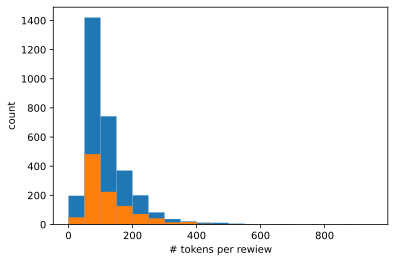

In [61]:
train_iter, test_iter, vocab, test_rew, test_labels = load_data(train_df, test_df, 64, 150)

In [40]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(LSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, 
                               num_hiddens, 
                               num_layers=num_layers, 
                               bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 3)
    
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.RNN(embed_size, 
                               num_hiddens, 
                               num_layers=num_layers, 
                               bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 3)
    
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


class GRU(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(GRU, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.GRU(embed_size, 
                               num_hiddens, 
                               num_layers=num_layers, 
                               bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 3)
    
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


In [41]:
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score
def results(model, x, y_true):
    y_pred = []
    for seq in x:
        seq = torch.tensor(vocab[seq.split()], device=d2l.try_gpu())
        label = torch.argmax(net(seq.reshape(1,-1)), dim=1)
        y_pred.append(float(label))
    print("accuracy_score is  {:.2f}%".format(accuracy_score(y_true, y_pred)*100))
    print("balanced_accuracy_score is  {:.2f}%".format(balanced_accuracy_score(y_true, y_pred)*100))
    print("f1_score is  {:.2f}%".format(f1_score(y_true, y_pred, average='weighted')*100))
    print("recall_score is  {:.2f}%".format(recall_score(y_true, y_pred, average='weighted')*100))
    print("precision_score is  {:.2f}%".format(precision_score(y_true, y_pred, average='weighted')*100))
    print()

In [63]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = RNN(len(vocab), embed_size, num_hiddens, num_layers)

In [64]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if 'weight' in param:
                nn.init.xavier_uniform(m._parameters[param])
net.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


RNN(
  (embedding): Embedding(5218, 100)
  (encoder): RNN(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=3, bias=True)
)

In [9]:
glove_embeding = d2l.TokenEmbedding('glove.6b.100d')

In [66]:
embeds = glove_embeding[vocab.idx_to_token]
embeds.shape

torch.Size([5218, 100])

In [67]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.735, train acc 0.710, test acc 0.667
83.1 examples/sec on [device(type='cpu')]


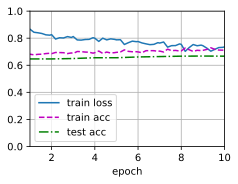

In [68]:
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [42]:
results(net, test_rew, list(test_labels))


accuracy_score is  66.41%
balanced_accuracy_score is  40.35%
f1_score is  58.15%
recall_score is  66.41%
precision_score is  56.05%



In [17]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net_LSTM = LSTM(len(vocab), embed_size, num_hiddens, num_layers)
net_LSTM.apply(init_weights)
net_LSTM.embedding.weight.data.copy_(embeds)
net_LSTM.embedding.weight.requires_grad = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


LSTM(
  (embedding): Embedding(5218, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=3, bias=True)
)

loss 0.705, train acc 0.715, test acc 0.670
74.7 examples/sec on [device(type='cpu')]


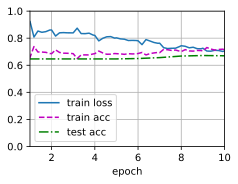

In [18]:
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net_LSTM.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net_LSTM, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [43]:
results(net_LSTM, test_rew, list(test_labels))


accuracy_score is  66.41%
balanced_accuracy_score is  40.35%
f1_score is  58.15%
recall_score is  66.41%
precision_score is  56.05%



In [46]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net_GRU = GRU(len(vocab), embed_size, num_hiddens, num_layers)
net_GRU.apply(init_weights)
net_GRU.embedding.weight.data.copy_(embeds)
net_GRU.embedding.weight.requires_grad = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


loss 0.759, train acc 0.707, test acc 0.668
93.1 examples/sec on [device(type='cpu')]


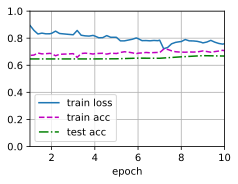

In [47]:
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net_GRU.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net_GRU, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [48]:
results(net_GRU, test_rew, list(test_labels))

accuracy_score is  66.41%
balanced_accuracy_score is  40.35%
f1_score is  58.15%
recall_score is  66.41%
precision_score is  56.05%



In [88]:
def load_data(train_df, test_df, batch_size, num_steps):
    train_df.loc[train_df["sideEffects"] == "No Side Effects", "s_label"] = 0
    train_df.loc[(train_df["sideEffects"] == "Mild Side Effects") | (train_df["sideEffects"] == "Moderate Side Effects"), "s_label"] = 1
    train_df.loc[(train_df["sideEffects"] == "Severe Side Effects") | (train_df["sideEffects"] == "Extremely Severe Side Effects"), "s_label"] = 2

    test_df.loc[test_df["sideEffects"] == "No Side Effects", "s_label"] = 0
    test_df.loc[(test_df["sideEffects"] == "Mild Side Effects") | (test_df["sideEffects"] == "Moderate Side Effects"), "s_label"] = 1
    test_df.loc[(test_df["sideEffects"] == "Severe Side Effects") | (test_df["sideEffects"] == "Extremely Severe Side Effects"), "s_label"] = 2

    train_df["sideEffectsReview"] = train_df.loc[:, "sideEffectsReview"].astype("string")
    train_df = train_df.fillna("")
    test_df["sideEffectsReview"] = test_df.loc[:, "sideEffectsReview"].astype("string")
    test_df = test_df.fillna("")

    train_tokens = d2l.tokenize(train_df.loc[:, "sideEffectsReview"], token='word')
    test_tokens = d2l.tokenize(test_df.loc[:, "sideEffectsReview"], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=3, reserved_tokens=['<pad>'])
    train_tk_per_rewiew = [len(line) for line in train_tokens]
    test_tk_per_rewiew = [len(line) for line in test_tokens]
    plt.xlabel("# tokens per rewiew")
    plt.ylabel("count")
    plt.hist(train_tk_per_rewiew, bins=range(0, 1000, 50))
    plt.hist(test_tk_per_rewiew, bins=range(0, 1000, 50))
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab["<pad>"]
    ) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab["<pad>"]
    ) for line in test_tokens])

    train_iter = d2l.load_array((train_features, 
                             torch.LongTensor(train_df.loc[:, "s_label"])), 
                             batch_size)
    test_iter = d2l.load_array((test_features, 
                             torch.LongTensor(test_df.loc[:, "s_label"])), 
                             batch_size)
    
    return train_iter, test_iter, vocab, test_df.loc[:, "sideEffectsReview"], test_df.loc[:, "s_label"]



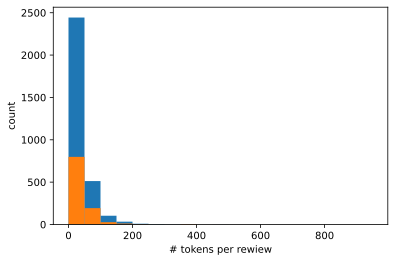

In [89]:
train_iter, test_iter, vocab, test_rew, test_labels = load_data(train_df, test_df, 64, 150)

In [91]:
embeds = glove_embeding[vocab.idx_to_token]
embeds.shape

torch.Size([3189, 100])

loss 0.663, train acc 0.720, test acc 0.675
214.9 examples/sec on [device(type='cpu')]


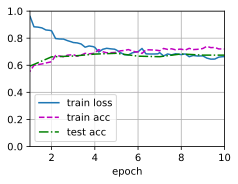

In [92]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = RNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [93]:
results(net, test_rew, list(test_labels))

accuracy_score is  60.04%
balanced_accuracy_score is  61.17%
f1_score is  61.70%
recall_score is  60.04%
precision_score is  66.55%



loss 0.662, train acc 0.721, test acc 0.688
73.5 examples/sec on [device(type='cpu')]


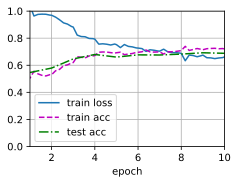

In [94]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net_LSTM = LSTM(len(vocab), embed_size, num_hiddens, num_layers)
net_LSTM.apply(init_weights)
net_LSTM.embedding.weight.data.copy_(embeds)
net_LSTM.embedding.weight.requires_grad = False
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net_LSTM.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net_LSTM, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [95]:
results(net_LSTM, test_rew, list(test_labels))

accuracy_score is  60.04%
balanced_accuracy_score is  61.17%
f1_score is  61.70%
recall_score is  60.04%
precision_score is  66.55%



loss 0.659, train acc 0.718, test acc 0.695
96.2 examples/sec on [device(type='cpu')]


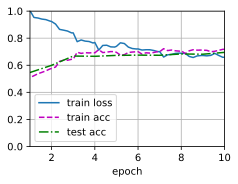

In [96]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net_GRU = GRU(len(vocab), embed_size, num_hiddens, num_layers)
net_GRU.apply(init_weights)
net_GRU.embedding.weight.data.copy_(embeds)
net_GRU.embedding.weight.requires_grad = False
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net_GRU.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net_GRU, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [97]:
results(net_GRU, test_rew, list(test_labels))

accuracy_score is  60.04%
balanced_accuracy_score is  61.17%
f1_score is  61.70%
recall_score is  60.04%
precision_score is  66.55%



In [98]:
def load_data(train_df, test_df, batch_size, num_steps):
    train_df.loc[train_df["effectiveness"] == "Ineffective", "b_label"] = 0
    train_df.loc[(train_df["effectiveness"] == "Moderately Effective") | (train_df["effectiveness"] == "Marginally Effective"), "b_label"] = 1
    train_df.loc[(train_df["effectiveness"] == "Considerably Effective") | (train_df["effectiveness"] == "Highly Effective"), "b_label"] = 2

    test_df.loc[test_df["effectiveness"] == "Ineffective", "b_label"] = 0
    test_df.loc[(test_df["effectiveness"] == "Moderately Effective") | (test_df["effectiveness"] == "Marginally Effective"), "b_label"] = 1
    test_df.loc[(test_df["effectiveness"] == "Considerably Effective") | (test_df["effectiveness"] == "Highly Effective"), "b_label"] = 2

    train_df["benefitsReview"] = train_df.loc[:, "benefitsReview"].astype("string")
    train_df = train_df.fillna("")
    test_df["benefitsReview"] = test_df.loc[:, "benefitsReview"].astype("string")
    test_df = test_df.fillna("")

    train_tokens = d2l.tokenize(train_df.loc[:, "benefitsReview"], token='word')
    test_tokens = d2l.tokenize(test_df.loc[:, "benefitsReview"], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=3, reserved_tokens=['<pad>'])
    train_tk_per_rewiew = [len(line) for line in train_tokens]
    test_tk_per_rewiew = [len(line) for line in test_tokens]
    plt.xlabel("# tokens per rewiew")
    plt.ylabel("count")
    plt.hist(train_tk_per_rewiew, bins=range(0, 1000, 50))
    plt.hist(test_tk_per_rewiew, bins=range(0, 1000, 50))
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab["<pad>"]
    ) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab["<pad>"]
    ) for line in test_tokens])

    train_iter = d2l.load_array((train_features, 
                             torch.LongTensor(train_df.loc[:, "b_label"])), 
                             batch_size)
    test_iter = d2l.load_array((test_features, 
                             torch.LongTensor(test_df.loc[:, "b_label"])), 
                             batch_size)
    
    return train_iter, test_iter, vocab, test_df.loc[:, "benefitsReview"], test_df.loc[:, "b_label"]


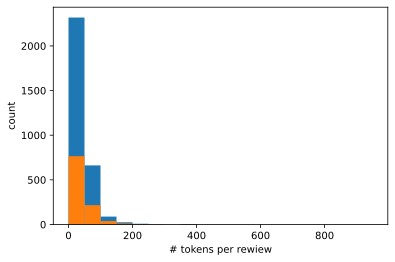

In [100]:
train_iter, test_iter, vocab, test_rew, test_labels = load_data(train_df, test_df, 64, 150)

In [101]:
embeds = glove_embeding[vocab.idx_to_token]
embeds.shape

torch.Size([3692, 100])

loss 0.615, train acc 0.752, test acc 0.702
165.6 examples/sec on [device(type='cpu')]


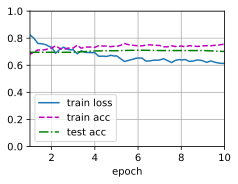

In [102]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = RNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [103]:
results(net, test_rew, list(test_labels))

accuracy_score is  70.66%
balanced_accuracy_score is  44.63%
f1_score is  62.80%
recall_score is  70.66%
precision_score is  62.45%



loss 0.644, train acc 0.731, test acc 0.700
81.7 examples/sec on [device(type='cpu')]


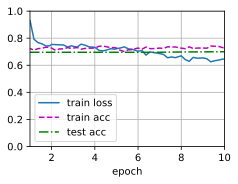

In [104]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net_LSTM = LSTM(len(vocab), embed_size, num_hiddens, num_layers)
net_LSTM.apply(init_weights)
net_LSTM.embedding.weight.data.copy_(embeds)
net_LSTM.embedding.weight.requires_grad = False
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net_LSTM.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net_LSTM, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [105]:
results(net_LSTM, test_rew, list(test_labels))

accuracy_score is  70.66%
balanced_accuracy_score is  44.63%
f1_score is  62.80%
recall_score is  70.66%
precision_score is  62.45%



loss 0.635, train acc 0.747, test acc 0.713
96.2 examples/sec on [device(type='cpu')]


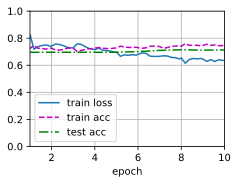

In [106]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net_GRU = GRU(len(vocab), embed_size, num_hiddens, num_layers)
net_GRU.apply(init_weights)
net_GRU.embedding.weight.data.copy_(embeds)
net_GRU.embedding.weight.requires_grad = False
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(net_GRU.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

d2l.train_ch13(net_GRU, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [107]:
results(net_GRU, test_rew, list(test_labels))

accuracy_score is  70.66%
balanced_accuracy_score is  44.63%
f1_score is  62.80%
recall_score is  70.66%
precision_score is  62.45%

